# Recurrent Gaussian Process (RGP) on Mocap data

In [34]:
# Necessary imports:

import autoreg
import GPy
import numpy as np
from matplotlib import pyplot as plt
from __future__ import print_function
import tables
from IPython.display import HTML
%matplotlib inline

In [2]:
# Function to compute root mean square error:

def comp_RMSE(a,b):
    return np.sqrt(np.square(a-b).mean())

In [3]:
# Function to show 3D image of a human given the data as an array

def gen_frames(data, data_mean, data_std, skel, imgpath):
    import os
    import GPy
    a = np.zeros((62,))
    fig = plt.figure(figsize=(8,10))
    ax = fig.add_subplot(111, projection='3d',aspect='equal')
    ax.view_init(elev=20., azim=65)
    fig.tight_layout()
    a[3:] = (data[0])*data_std+data_mean
    p = GPy.plotting.matplot_dep.visualize.skeleton_show(a, skel ,axes=ax)
    for i in xrange(data.shape[0]):
        a[3:] = (data[i])*data_std+data_mean
        p.modify(a)
        fig.savefig(os.path.join(imgpath,'%05d'%i+'.png'))


In [4]:
# Function to return( possibly download) Mocap data

from GPy.util.datasets import *
def cmu_mocap_xyz(subject, train_motions, test_motions=[], sample_every=4, data_set='cmu_mocap'):
    """Load a given subject's training and test motions from the CMU motion capture data."""
    # Load in subject skeleton.
    subject_dir = os.path.join(data_path, data_set)

    # Make sure the data is downloaded.
    all_motions = train_motions + test_motions
    resource = cmu_urls_files(([subject], [all_motions]))
    data_resources[data_set] = data_resources['cmu_mocap_full'].copy()
    data_resources[data_set]['files'] = resource['files']
    data_resources[data_set]['urls'] = resource['urls']
    if resource['urls']:
        download_data(data_set)

    skel = GPy.util.mocap.acclaim_skeleton(os.path.join(subject_dir, subject + '.asf'))
    
    
    for i in range(len(skel.vertices)):
        print i, skel.vertices[i].name     

    
    # 0 root
    # 1 lhipjoint
    # 2 lfemur
    # 3 ltibia
    # 4 lfoot
    # 5 ltoes
    # 6 rhipjoint
    # 7 rfemur
    # 8 rtibia
    # 9 rfoot
    # 10 rtoes
    # 11 lowerback
    # 12 upperback
    # 13 thorax
    # 14 lowerneck
    # 15 upperneck
    # 16 head
    # 17 lclavicle
    # 18 lhumerus
    # 19 lradius
    # 20 lwrist
    # 21 lhand
    # 22 lfingers
    # 23 lthumb
    # 24 rclavicle
    # 25 rhumerus
    # 26 rradius
    # 27 rwrist
    # 28 rhand
    # 29 rfingers
    # 30 rthumb

    
    
    
    
    # Set up labels for each sequence
    exlbls = np.eye(len(train_motions))

    # Load sequences
    tot_length = 0
    temp_Y = []
    temp_Yxyz = []
    temp_lbls = []
    #u_inds = [15,16,17]
    #root_inds = [0,1,2]
    u_inds=[17]
    root_inds = [2]
    
    for i in range(len(train_motions)):
        temp_chan = skel.load_channels(os.path.join(subject_dir, subject + '_' + train_motions[i] + '.amc'))
        #temp_xyz_chan = skel.to_xyz(temp_chan.flatten()) ## A
        # Apparently the above is equiv. to giving temp_chan[0,:]. It's returning a 31 x 3 matrix.
        # I need to do this for every temp_chan[j,:], and serialize the result. The toe should be the
        # very last dimension (I think).
        #temp_xyz_chan = np.zeros((temp_chan.shape[0],93))
        #A -------
        temp_xyz_chan = np.zeros((temp_chan.shape[0],len(u_inds)))                        
        for j in range(temp_xyz_chan.shape[0]):                                 
            foo = skel.to_xyz(temp_chan[j,:]).flatten()
            temp_xyz_chan[j,:] = foo[u_inds] - foo[root_inds]
        #----A
        temp_Y.append(temp_chan[::sample_every, :])
        temp_Yxyz.append(temp_xyz_chan[::sample_every, :]) ## A
        temp_lbls.append(np.tile(exlbls[i, :], (temp_Y[i].shape[0], 1)))
        tot_length += temp_Y[i].shape[0]

    Y = np.zeros((tot_length, temp_Y[0].shape[1]))
    Yxyz = np.zeros((tot_length, temp_Yxyz[0].shape[1])) #A
    lbls = np.zeros((tot_length, temp_lbls[0].shape[1]))

    #pb.plot(temp_Yxyz[-1][:,15:18]-temp_Yxyz[-1][:,0:3],'x-')

    end_ind = 0
    for i in range(len(temp_Y)):
        start_ind = end_ind
        end_ind += temp_Y[i].shape[0]
        Y[start_ind:end_ind, :] = temp_Y[i]
        Yxyz[start_ind:end_ind, :] = temp_Yxyz[i] #A
        lbls[start_ind:end_ind, :] = temp_lbls[i]
    if len(test_motions) > 0:
        temp_Ytest = []
        temp_lblstest = []
        temp_Yxyz_test = []

        testexlbls = np.eye(len(test_motions))
        tot_test_length = 0
        for i in range(len(test_motions)):
            temp_chan = skel.load_channels(os.path.join(subject_dir, subject + '_' + test_motions[i] + '.amc'))
            #A -------
            temp_xyz_chan = np.zeros((temp_chan.shape[0],len(u_inds)))                        
            for j in range(temp_xyz_chan.shape[0]):                                 
                foo = skel.to_xyz(temp_chan[j,:]).flatten()
                temp_xyz_chan[j,:] = foo[u_inds] - foo[root_inds]
            #----A
            temp_Ytest.append(temp_chan[::sample_every, :])
            temp_Yxyz_test.append(temp_xyz_chan[::sample_every, :]) ## A
            temp_lblstest.append(np.tile(testexlbls[i, :], (temp_Ytest[i].shape[0], 1)))
            tot_test_length += temp_Ytest[i].shape[0]

        # Load test data
        Ytest = np.zeros((tot_test_length, temp_Ytest[0].shape[1]))
        Yxyz_test = np.zeros((tot_test_length, temp_Yxyz_test[0].shape[1])) #A
        lblstest = np.zeros((tot_test_length, temp_lblstest[0].shape[1]))

        end_ind = 0
        for i in range(len(temp_Ytest)):
            start_ind = end_ind
            end_ind += temp_Ytest[i].shape[0]
            Ytest[start_ind:end_ind, :] = temp_Ytest[i]
            Yxyz_test[start_ind:end_ind, :] = temp_Yxyz_test[i] #A
            lblstest[start_ind:end_ind, :] = temp_lblstest[i]
    else:
        Ytest = None
        lblstest = None

    info = 'Subject: ' + subject + '. Training motions: '
    for motion in train_motions:
        info += motion + ', '
    info = info[:-2]
    if len(test_motions) > 0:
        info += '. Test motions: '
        for motion in test_motions:
            info += motion + ', '
        info = info[:-2] + '.'
    else:
        info += '.'
    if sample_every != 1:
        info += ' Data is sub-sampled to every ' + str(sample_every) + ' frames.'
    return data_details_return({'Y': Y, 'lbls' : lbls, 'Ytest': Ytest, 'lblstest' : lblstest, 'info': info, 'skel': skel,'Yxyz':Yxyz,'Yxyz_test':Yxyz_test,'u_inds':u_inds,'root_inds':root_inds,'Yxyz_list':temp_Yxyz,'Yxyz_list_test':temp_Yxyz_test}, data_set)




## Load the dataset

In [5]:
# Function for loading the data.
def load_data_xyz():
    #train_motions = ['01', '02', '03', '04', # walking
    #            '17', '18', '19', '20'] # running
    #test_motions = ['05','06','07','08','09','10','11','12','13','14','15','16','21','22','23','24','25','26']
    train_motions = ['01', '02', '03', '04'] # walking
    test_motions = ['05','06','07','08']
    data = cmu_mocap_xyz('35', train_motions, test_motions, sample_every=4, data_set='cmu_mocap')
    return data

## Prepare training data

In [6]:
data = load_data_xyz() # get the data

0 root
1 lhipjoint
2 lfemur
3 ltibia
4 lfoot
5 ltoes
6 rhipjoint
7 rfemur
8 rtibia
9 rfoot
10 rtoes
11 lowerback
12 upperback
13 thorax
14 lowerneck
15 upperneck
16 head
17 lclavicle
18 lhumerus
19 lradius
20 lwrist
21 lhand
22 lfingers
23 lthumb
24 rclavicle
25 rhumerus
26 rradius
27 rwrist
28 rhand
29 rfingers
30 rthumb


In [35]:
# Normalize train data. Each of train and test datasets consist of 4 episodes.

y = data['Y']
u = data['Yxyz_list']
u_flat = np.vstack(u)

lbls = data['lbls']
data_out_train = y

# 3 dimensions are cut because they are 3-D positions of the human
data_out_train = y[:,3:]
data_out_mean  = data_out_train.mean(axis=0)
data_out_std   = data_out_train.std(axis=0)
data_out_train = (y[:,3:]-data_out_mean)/data_out_std
#data_out_train_list = [data_out_train[np.where(lbls[:,i]==1)[0]][1:] for i in range(lbls.shape[1])]
data_out_train_list = [data_out_train[np.where(lbls[:,i]==1)[0]] for i in range(lbls.shape[1])]


data_in_train_list = u
u_flat_mean = u_flat.mean(axis=0)
u_flat_std = u_flat.std(axis=0)
data_in_train = (u_flat-u_flat_mean)/u_flat_std

data_in_train_list = [(d-u_flat_mean)/u_flat_std for d in data_in_train_list]

print(y.shape)
print(data_out_train.shape)
print(u_flat.shape)
print(data_in_train.shape)

(408, 62)
(408, 59)
(408, 1)
(408, 1)


### Plot training data (Inputs)

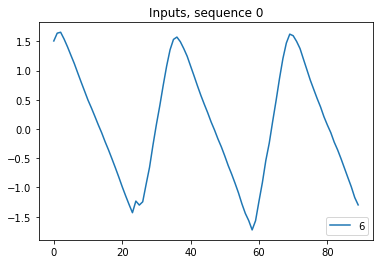

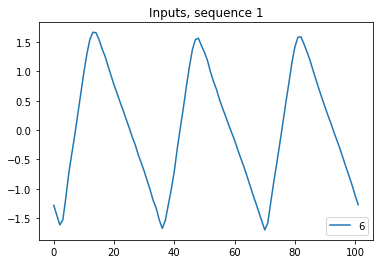

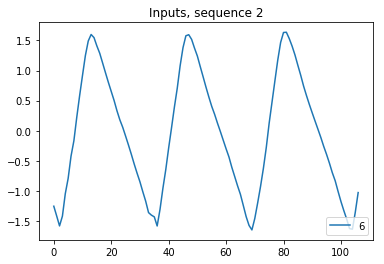

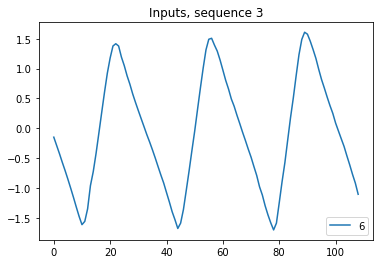

In [25]:
# Plot training inputs for each of 4 episodes. They are one dimensional

for (s,_) in enumerate(data_in_train_list):
    plt.figure()
    plt.title('Inputs, sequence %i' % (s,) )
    plt.plot( data_in_train_list[s] )
    plt.legend(loc=4)
        
del s

### Plot training data (Outputs)

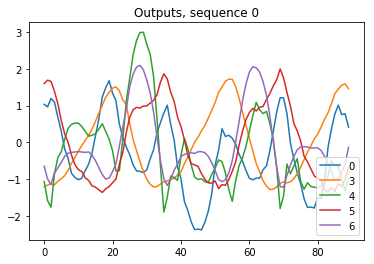

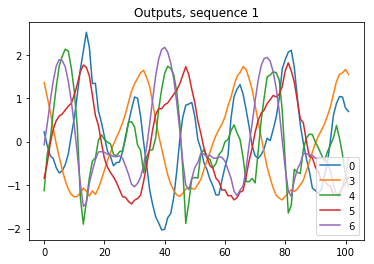

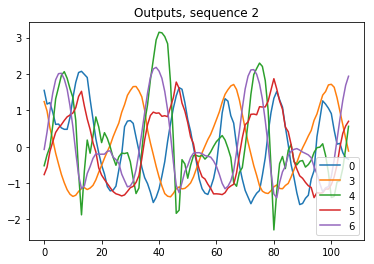

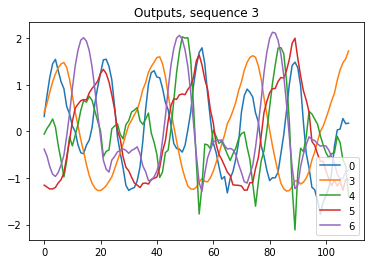

In [26]:
# Plot the training data. Certain dimensions are plotted for each episode.
# Dimensions with indices 44 and 56 are constant

train_plot_dimensions = [0,3,4,5,6] # dimensions to plot

for (s,_) in enumerate(data_out_train_list):
    plt.figure()
    plt.title('Outputs, sequence %i' % (s,) )
    for i in train_plot_dimensions:
        plt.plot( data_out_train_list[s][:,i], label = '%i' % (i,) )
    if len(train_plot_dimensions) < 10:
        plt.legend(loc=4)
        
del train_plot_dimensions, s, i

## Prepare test data

In [8]:
# Normalize test data

ytest = data['Ytest']
lblstest = data['lblstest']
u = data['Yxyz_list_test']

#data_out_test = ytest
data_out_test= ytest[:,3:]

data_out_test = (ytest[:,3:]-data_out_mean)/data_out_std
data_out_test_list = [data_out_test[np.where(lblstest[:,i]==1)[0]] for i in range(lblstest.shape[1])]

data_in_test_list = u
data_in_test_list = [(d-u_flat_mean)/u_flat_std for d in u]

### Plot test data (Inputs)

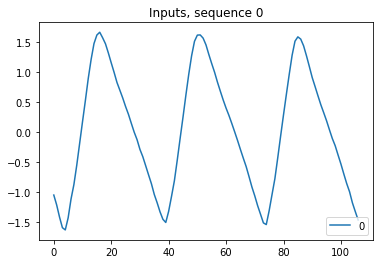

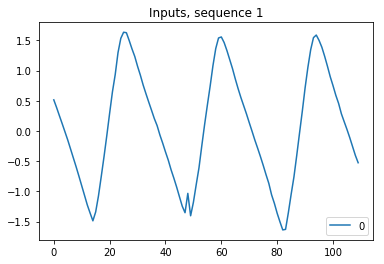

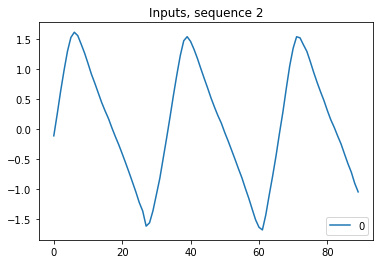

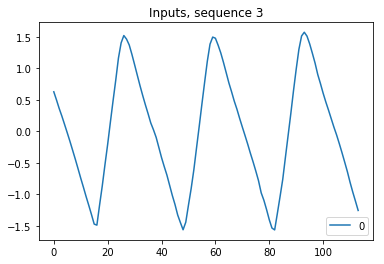

In [29]:
# # Plot test inputs for each of 4 episodes. They are one dimensional

for (s,_) in enumerate(data_in_test_list):
    plt.figure()
    plt.title('Inputs, sequence %i' % (s,) )
    plt.plot( data_in_test_list[s], label='0' )
    plt.legend(loc=4)
        
del s

### Plot test data (Outputs)

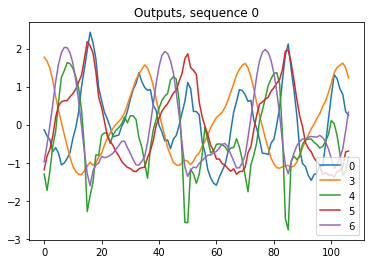

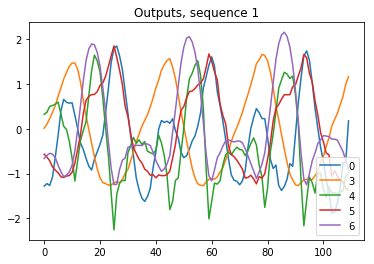

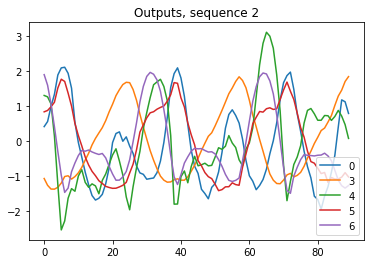

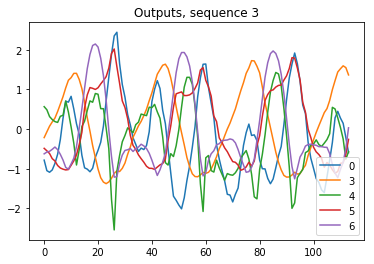

In [30]:
# Plot the training data. Certain dimensions are plotted for each episode.
# Dimensions with indices 44 and 56 are constant

train_plot_dimensions = [0,3,4,5,6] # dimensions to plot

for (s,_) in enumerate(data_out_test_list):
    plt.figure()
    plt.title('Outputs, sequence %i' % (s,) )
    for i in train_plot_dimensions:
        plt.plot( data_out_test_list[s][:,i], label = '%i' % (i,) )
    if len(train_plot_dimensions) < 10:
        plt.legend(loc=4)
        
del train_plot_dimensions, s, i

## Fit a model without NN-constraint

In [116]:
# This is a function for training (or loading saved) model
# There are 2 model types. 1 - RGP model without back-constrains
# 2 - with back-constrains as a multilayer perceptron.

experiment_path = '/Users/grigoral/work/code/RGP/examples' 
def experiment(debug = False, train_model=False, model = 1, input_scaling_factor=1):
    
    if debug: import pdb; pdb.set_trace()
    #=============================
    # Initialize a model
    #=============================
    
    Q = 100 # 200
    win_in = 20 # 20
    win_out = 20 # 20
    use_controls = True
    back_cstr = False
    
    if input_scaling_factor is None:
        input_scaling_factor = 1
        
    if model == 1:
    
        if use_controls:
            m = autoreg.DeepAutoreg([0, win_out, win_out], data_out_train_list, U=[d*input_scaling_factor for d in data_in_train_list], U_win=win_in, X_variance=0.05,
                                num_inducing=Q, back_cstr=back_cstr, MLP_dims=[300,200], nDims=[data_out_train.shape[1],1,1],
                                 kernels=[GPy.kern.RBF(win_out,ARD=True,inv_l=True, useGPU=False),
                                 GPy.kern.RBF(win_out+win_out,ARD=True,inv_l=True, useGPU=False),
                                 GPy.kern.RBF(win_out+win_in,ARD=True,inv_l=True, useGPU=False)])           
 
        else:
            m = autoreg.DeepAutoreg([0, win_out], data_in_train, U=None, U_win=win_in, X_variance=0.05,
                                num_inducing=Q, back_cstr=back_cstr, MLP_dims=[200,100], nDims=[data_out_train.shape[1],1],
                                 kernels=[GPy.kern.RBF(win_out,ARD=True,inv_l=True, useGPU=False),
                                 GPy.kern.RBF(win_out,ARD=True,inv_l=True, useGPU=False)])
    
    elif model == 2:
        #=============================
        # Model with NN-constraint
        #=============================
        Q = 500
        win_in = 20
        win_out = 20
        
        use_controls = True
        back_cstr = True
        
        m = autoreg.DeepAutoreg([0, win_out], data_out_train_list, U=[d*input_scaling_factor for d in data_in_train_list], U_win=win_in, X_variance=0.05,
                            num_inducing=Q, back_cstr=back_cstr, MLP_dims=[500,200], nDims=[data_out_train.shape[1],1],
                             kernels=[GPy.kern.MLP(win_out,bias_variance=10.),
                             GPy.kern.MLP(win_out+win_in,bias_variance=10.)])
        #                      kernels=[GPy.kern.RBF(win_out,ARD=True,inv_l=True, useGPU=True),
        #                      GPy.kern.RBF(win_out+win_in,ARD=True,inv_l=True, useGPU=True)])
    
    
    # Initialize latent variables and inducing points:
    if debug: import pdb; pdb.set_trace()
    if not back_cstr:
        pp = GPy.util.pca.PCA(data_out_train)
        pca_projection = pp.project(data_out_train, 1)
        pca_projection = (pca_projection - pca_projection.mean()) / pca_projection.std()
        
        for i_seq in range(lbls.shape[1]):
            m.layer_1.Xs_flat[i_seq].mean[:] = pca_projection[ np.where(lbls[:,i_seq]==1)[0],:]
            m.layer_2.Xs_flat[i_seq].mean[:] = pca_projection[ np.where(lbls[:,i_seq]==1)[0],:]
            
        m._trigger_params_changed()
        
        # Random permutation for Z
    #     perm = np.random.permutation(range(m.layer_1.X.mean.shape[0]))
    #     m.layer_1.Z[:] = m.layer_1.X.mean[perm[0:Q],:].values.copy()
        
        # K-means initialization
# m -> This was done already in layer initialization?       
#        from sklearn.cluster import KMeans
#        km = KMeans(n_clusters=m.layer_1.Z.shape[0],n_init=1000,max_iter=100)
#        km.fit(m.layer_1.X.mean.values.copy())
#        m.layer_1.Z[:] = km.cluster_centers_.copy()
#        
#        km = KMeans(n_clusters=m.layer_0.Z.shape[0],n_init=1000,max_iter=100)
#        km.fit(m.layer_0.X.mean.values.copy())
#        m.layer_0.Z[:] = km.cluster_centers_.copy()
#        
#        km = KMeans(n_clusters=m.layer_2.Z.shape[0],n_init=1000,max_iter=100)
#        km.fit(m.layer_2.X.mean.values.copy())
#        m.layer_2.Z[:] = km.cluster_centers_.copy()
#    
#        m._trigger_params_changed()
# m <-      
    

    # Initialize kernel parameters    
    if debug: import pdb; pdb.set_trace()
        
    for i in range(m.nLayers):
        if not back_cstr:
            m.layers[i].kern.inv_l[:]  = 1./((m.layers[i].X.mean.values.max(0)-m.layers[i].X.mean.values.min(0))/np.sqrt(2.))**2
        else:
            # Ask: MLP kernel?
            # m.layers[i].kern.inv_l[:]  = 1./9.#((m.layers[i].X.mean.values.max(0)-m.layers[i].X.mean.values.min(0))/np.sqrt(2.))
            pass
        m.layers[i].likelihood.variance[:] = 0.01*data_out_train.var()
        m.layers[i].kern.variance.fix(warning=False)
        m.layers[i].likelihood.fix(warning=False)
    
    if back_cstr:
        m.layer_1.kern.variance[:] = np.vstack([ xs.mean.values for xs in m.layer_1.Xs_flat]).var()
        m.layer_1.likelihood.variance[:] = 0.01
        m.layer_1.Z.fix()
    else:
        m.layer_1.kern.variance[:] = np.vstack([ xs.mean.values for xs in m.layer_1.Xs_flat]).var()
        m.layer_2.kern.variance[:] = np.vstack([ xs.mean.values for xs in m.layer_2.Xs_flat]).var()
    
        m.layer_1.likelihood.variance[:] = 0.01 * m.layer_1.Xs_flat[0].mean.var()
        m.layer_2.likelihood.variance[:] = 0.01 * m.layer_2.Xs_flat[0].mean.var()
    
    m._trigger_params_changed()
    
    m_init = m.copy()
    m = m_init.copy()
    print('Model after initialization:')
    print(m)
    
    file_name = os.path.join(experiment_path, 'alex_walk_run_m%i_sf%1.1f.h5' % (model, input_scaling_factor) )
    
    if debug: import pdb; pdb.set_trace()
    if train_model:
        # optimization
        m.optimize('bfgs',messages=1,max_iters=100) # 100
        for i in range(m.nLayers):
            m.layers[i].kern.variance.constrain_positive(warning=False)
        for i in range(m.nLayers):
            m.layers[i].likelihood.constrain_positive(warning=False)
        m.optimize('bfgs',messages=1,max_iters=10000)
        
        m.save(file_name )
    else:
        
        #=============================
        # Load a trained model
        #=============================
        import tables
        with tables.open_file(file_name,'r') as f:
            ps = f.root.param_array[:]
            f.close()
            m.param_array[:] = ps
            m._trigger_params_changed()
    
    print('Trained or loaded model:')
    print(m)
    
    if debug: import pdb; pdb.set_trace()
    # Free-run on the training data
    pds_train = [m.freerun(U=data_in, m_match=True) for data_in in data_in_train_list]
    
    rmse = [comp_RMSE(pd.mean[win_out:],gt[win_out+win_in:]) for pd, gt in zip(pds_train, data_out_train_list)]
    rmse_all = comp_RMSE(np.vstack([pd.mean[win_out:] for pd in pds_train]),np.vstack([gt[win_out+win_in:] for gt in data_out_train_list]))
    print(rmse)
    print("Train overall RMSE: "+str(rmse_all))
    
    # Free-run on the test data
    pds_test = [m.freerun(U=data_in, m_match=True) for data_in in data_in_test_list]
    
    rmse = [comp_RMSE(pd.mean[win_out:],gt[win_out+win_in:]) for pd, gt in zip(pds_test, data_out_test_list)]
    rmse_all = comp_RMSE(np.vstack([pd.mean[win_out:] for pd in pds_test]),np.vstack([gt[win_out+win_in:] for gt in data_out_test_list]))
    
    print(rmse)
    print("Test overall RMSE: "+str(rmse_all))
    
    if debug: import pdb; pdb.set_trace()s
    os.system( u'rm %s/*.png ' % (os.path.join( experiment_path, 'imgs'), ) )    
    gen_frames(pds_test[0].mean[win_out:],data_out_mean, data_out_std, data['skel'], os.path.join( experiment_path, 'imgs' ) )
    
    video_file_name = os.path.join(experiment_path, 'alex_pred_walk_run_m%i_sf%1.1f.mp4' % (model, input_scaling_factor) )
    video_pattern = os.path.join(experiment_path, 'imgs/%05d.png' )
    os.system(u'avconv -y -r 10 -i %s -qscale 2 %s' % ( video_pattern, video_file_name) )
    
    globals().update(locals()); return # Alex

> /Users/grigoral/work/code/RGP/autoreg/model.py(22)__init__()
-> Ys, Us = Y,U
(Pdb) c
Model after initialization:

Name : autoreg
Objective : 856009.548664
Number of Parameters : 11738
Number of Optimization Parameters : 11732
Updates : True
Parameters:
  autoreg.                         |             value  |  constraints  |  priors
  layer_2.inducing_inputs          |         (100, 40)  |               |        
  layer_2.rbf.variance             |               1.0  |   +ve fixed   |        
  layer_2.rbf.inv_lengthscale      |             (40,)  |      +ve      |        
  layer_2.Gaussian_noise.variance  |  0.00766595140845  |   +ve fixed   |        
  layer_2.qX_0.mean                |           (90, 1)  |               |        
  layer_2.qX_0.variance            |           (90, 1)  |      +ve      |        
  layer_2.qX_1.mean                |          (102, 1)  |               |        
  layer_2.qX_1.variance            |          (102, 1)  |      +ve      |        
  layer

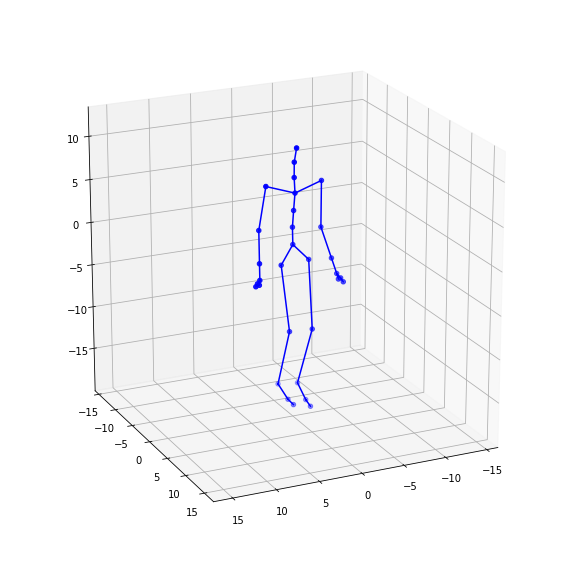

In [124]:
# Train (or load) the model and make predictions for train and test data. All internal function variables are exported as global
experiment(debug=False, train_model=False, model = 1, input_scaling_factor=1)

## Evaluate the model

### Plot initialization

1 0 qX_0 (90, 1) (90, 1)
1 1 qX_1 (102, 1) (102, 1)
1 2 qX_2 (107, 1) (107, 1)
1 3 qX_3 (109, 1) (109, 1)
2 0 qX_0 (90, 1) (90, 1)
2 1 qX_1 (102, 1) (102, 1)
2 2 qX_2 (107, 1) (107, 1)
2 3 qX_3 (109, 1) (109, 1)


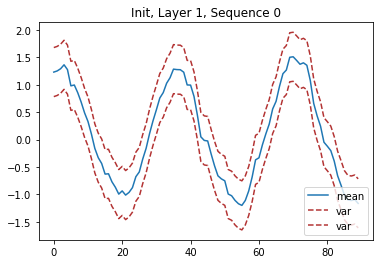

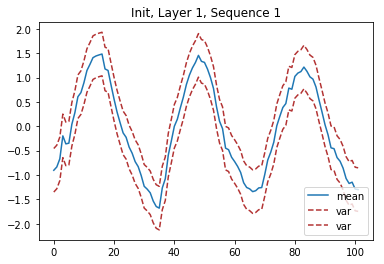

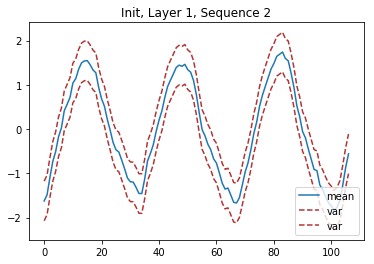

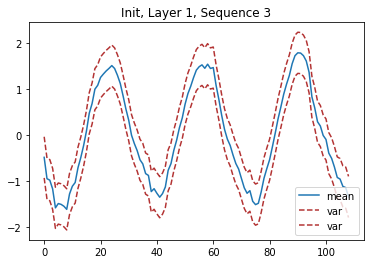

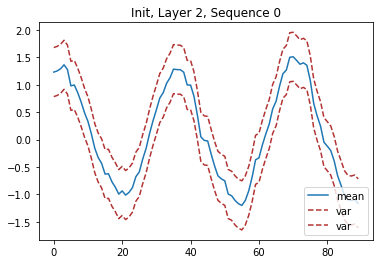

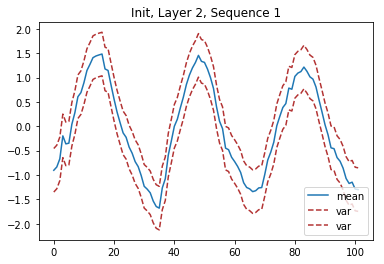

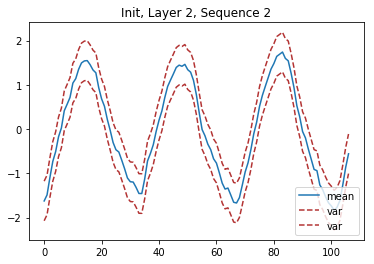

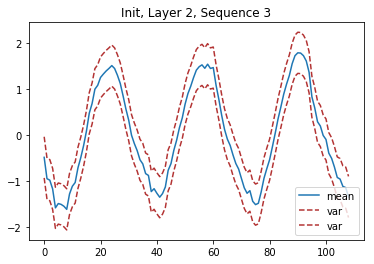

In [129]:
# This cell is works only for model=1.

# initial model m_init
# in m_init.layers layers order is in different order. e.g. m_init.layers[0] is m_init.layer_2

# Probably initialization as output
for l in range((m_init.nLayers-2),-1,-1):
    for s in range(len(m_init.Ys)):
        lXs_name = 'qX_%i' % s
        layer_real_no = 2-l
        layer_seq_means = getattr(m_init.layers[l],lXs_name).mean
        layer_seq_vars = getattr(m_init.layers[l],lXs_name).variance
        print(layer_real_no,s,lXs_name, layer_seq_means.shape,layer_seq_means.shape)
        plt.figure()
        plt.title('Init, Layer %i, Sequence %i' % (layer_real_no,s,) )
        plt.plot( layer_seq_means, label = 'mean' )
        plt.plot( layer_seq_means +\
                 2*np.sqrt( layer_seq_vars), label = 'var',color=[0.7,0.2,0.2],linestyle='--' )
        plt.plot( layer_seq_means -\
                 2*np.sqrt( layer_seq_vars), label = 'var',color=[0.7,0.2,0.2],linestyle='--' )
        plt.legend(loc=4)
        
del s, l

In [ ]:
### Plot predictions (train data)

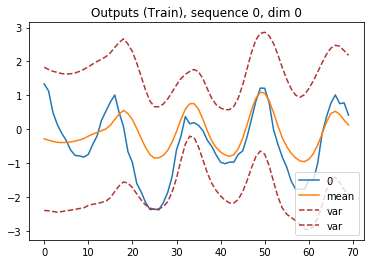

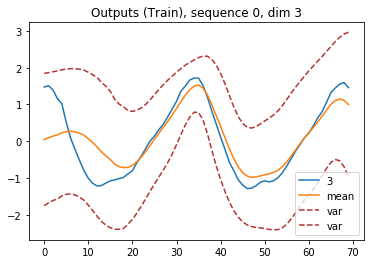

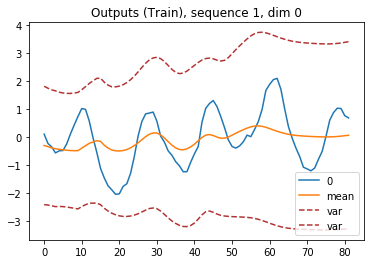

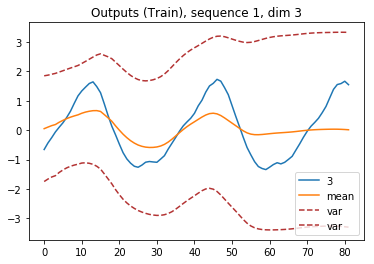

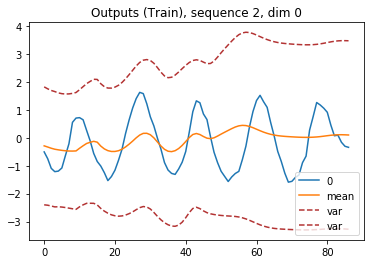

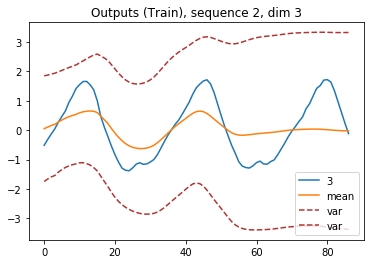

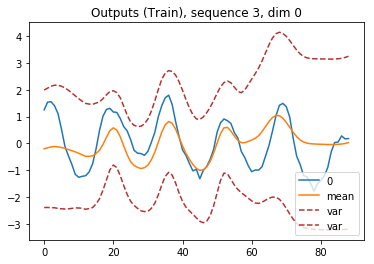

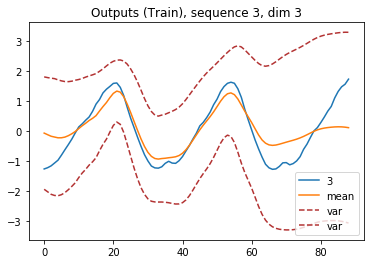

In [125]:
train_plot_dimensions = [ [0,3], [0,3], [ 0,3], [0,3] ] # sequence, coordinates

for (seq_no, dims) in enumerate(train_plot_dimensions):
    for d in dims:
        true_data = data_out_train_list[seq_no][:,d][win_out:]
        pred_mean = pds_train[seq_no].mean[:,d].values
        pred_var = pds_train[seq_no].variance[:,d].values
        
        plt.figure()
        plt.title('Outputs (Train), sequence %i, dim %i' % (seq_no,d ) )
        plt.plot( true_data, label = '%i' % (d,) )
        
        #print(true_data.shape, pred_mean.shape, pred_var.shape)
        
        plt.plot( pred_mean, label = 'mean' )
        plt.plot( pred_mean +\
                 2*np.sqrt( pred_var), label = 'var',color=[0.7,0.2,0.2],linestyle='--' )
        plt.plot( pred_mean -\
                 2*np.sqrt( pred_var), label = 'var',color=[0.7,0.2,0.2],linestyle='--' )
        if len(dims) < 10:
            plt.legend(loc=4)
        
del train_plot_dimensions, seq_no, dims, d, pred_mean, pred_var

### Plot predictions (test data)

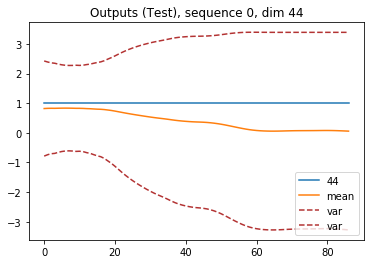

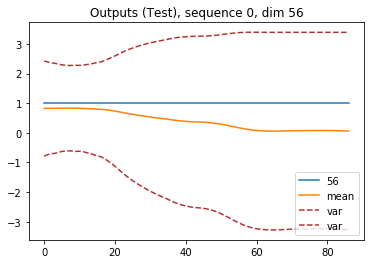

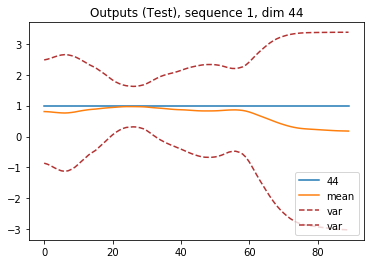

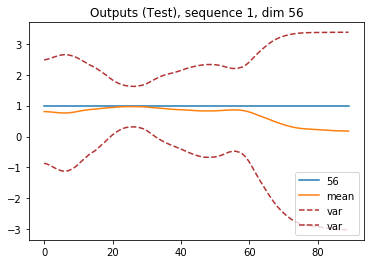

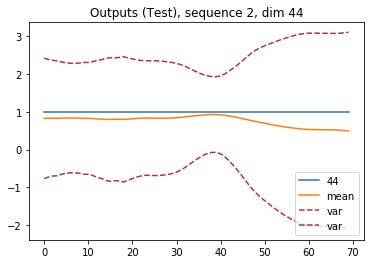

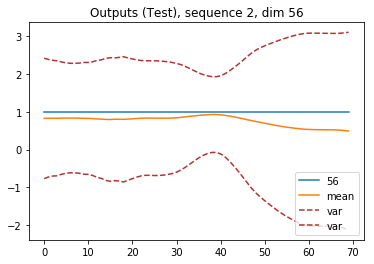

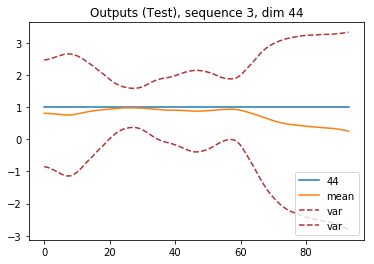

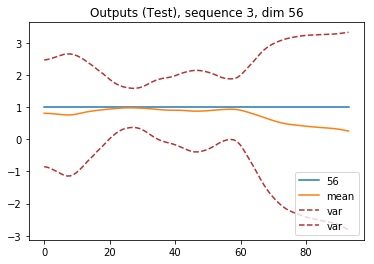

In [127]:
test_plot_dimensions = [ [44,56], [44,56], [44,56], [44,56] ] # sequence, coordinates

for (seq_no, dims) in enumerate(test_plot_dimensions):
    for d in dims:
        true_data = data_out_test_list[seq_no][:,d][win_out:]
        pred_mean = pds_test[seq_no].mean[:,d].values
        pred_var = pds_test[seq_no].variance[:,d].values
        
        plt.figure()
        plt.title('Outputs (Test), sequence %i, dim %i' % (seq_no,d ) )
        plt.plot( true_data, label = '%i' % (d,) )
        
        #print(true_data.shape, pred_mean.shape, pred_var.shape)
        
        plt.plot( pred_mean, label = 'mean' )
        plt.plot( pred_mean +\
                 2*np.sqrt( pred_var), label = 'var',color=[0.7,0.2,0.2],linestyle='--' )
        plt.plot( pred_mean -\
                 2*np.sqrt( pred_var), label = 'var',color=[0.7,0.2,0.2],linestyle='--' )
        if len(dims) < 10:
            plt.legend(loc=4)
        
del test_plot_dimensions, seq_no, dims, d, pred_mean, pred_var

In [ ]:
### Plot latent space (test)

In [ ]:
# in m_init.layers layers order is in different order. e.g. m_init.layers[0] is m_init.layer_2

# Probably initialization as output
for l in range((m.nLayers-2),-1,-1):
    for s in range(len(m_init.Ys)):
        lXs_name = 'qX_%i' % s
        layer_real_no = 2-l
        layer_seq_means = getattr(m_init.layers[l],lXs_name).mean
        layer_seq_vars = getattr(m_init.layers[l],lXs_name).variance
        print(layer_real_no,s,lXs_name, layer_seq_means.shape,layer_seq_means.shape)
        plt.figure()
        plt.title('Init, Layer %i, Sequence %i' % (layer_real_no,s,) )
        plt.plot( layer_seq_means, label = 'mean' )
        plt.plot( layer_seq_means +\
                 2*np.sqrt( layer_seq_vars), label = 'var',color=[0.7,0.2,0.2],linestyle='--' )
        plt.plot( layer_seq_means -\
                 2*np.sqrt( layer_seq_vars), label = 'var',color=[0.7,0.2,0.2],linestyle='--' )
        plt.legend(loc=4)
        
del s, l

## Others

In [130]:
HTML("""
<video width="480" height="480" controls>
  <source src="%s" type="video/mp4">
</video>
""" % video_file_name)